In [9]:
%pip install --upgrade pip

%pip install -q -r ./requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import json
import matplotlib.pyplot as plt
import tiktoken


# Use GPT-3.5 tokenizer for token estimation
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [11]:
import nltk

# Set up the data path
nltk.data.path.clear()
nltk.data.path.append("./nltk_data")

# Download punkt_tab (the newer version that NLTK expects)
nltk.download("punkt_tab", download_dir="./nltk_data")

from nltk.tokenize import sent_tokenize

# Your sample text (make sure this variable is defined)
sample = "This is your sample text. It should work now. Let's test it!"

print(sent_tokenize(sample))

[nltk_data] Downloading package punkt_tab to ./nltk_data...


['This is your sample text.', 'It should work now.', "Let's test it!"]


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [12]:
def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

In [13]:
def dynamic_stride(token_len: int):
    if token_len > 600:
        return 200
    elif token_len > 300:
        return 150
    else:
        return 75

In [14]:
def sentence_window_chunks(text, max_tokens=300):
    sentences = sent_tokenize(text)
    chunks = []
    current = []
    current_len = 0

    i = 0
    while i < len(sentences):
        sentence = sentences[i]
        token_count = count_tokens(sentence)

        if current_len + token_count <= max_tokens:
            current.append(sentence)
            current_len += token_count
            i += 1
        else:
            if current:
                chunks.append(" ".join(current))
                stride_tokens = dynamic_stride(current_len)

                # Slide the window
                stride_len = 0
                while current and stride_len < stride_tokens:
                    removed = current.pop(0)
                    stride_len += count_tokens(removed)
                current_len = sum(count_tokens(s) for s in current)
            else:
                # Handle very long single sentence
                chunks.append(sentence)
                i += 1

    if current:
        chunks.append(" ".join(current))

    return chunks

In [15]:
source_file = "./chunks_raw.jsonl"
sliding_chunks = []

with open(source_file, "r", encoding="utf-8") as f:
    for line in f:
        original = json.loads(line)
        text = original["chunk"]
        new_chunks = sentence_window_chunks(text)

        for i, chunk in enumerate(new_chunks):
            sliding_chunks.append(
                {
                    **original,
                    "chunk": chunk,
                    "heading": f"{original['heading']} (sliding {i+1})",
                }
            )

In [16]:
def get_chunk_writer(filename):
    f = open(filename, "w", encoding="utf-8")

    def write_chunk(chunk):
        f.write(json.dumps(chunk) + "\n")

    return write_chunk, f.close


write_chunk, close_writer = get_chunk_writer("chunks_sliding.jsonl")

for chunk in sliding_chunks:
    write_chunk(chunk)

close_writer()

Total chunks: 209
Token range: 5 to 430
Chunks > 300 tokens: 2


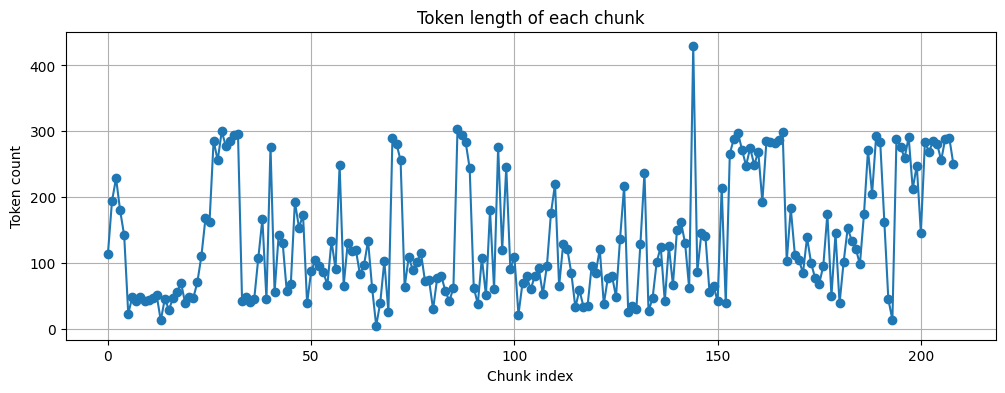

In [17]:
token_lengths = [count_tokens(c["chunk"]) for c in sliding_chunks]

print(f"Total chunks: {len(sliding_chunks)}")
print(f"Token range: {min(token_lengths)} to {max(token_lengths)}")
print(f"Chunks > 300 tokens: {sum(t > 300 for t in token_lengths)}")

plt.figure(figsize=(12, 4))
plt.plot(token_lengths, marker="o")
plt.title("Token length of each chunk")
plt.xlabel("Chunk index")
plt.ylabel("Token count")
plt.grid(True)
plt.show()

In [18]:
for i in range(3):
    print(f"\n--- Chunk {i} ---\n{sliding_chunks[i]['chunk'][:300]}")
    print(f"\n--- Chunk {i+1} ---\n{sliding_chunks[i+1]['chunk'][:300]}")


--- Chunk 0 ---
The `tree` command shows the folder structure of the current directory. Use the `-d` option to only show directories. The `-I` option lets you exclude certain directories. For example:

```
tree -I node_modules
```

To exclude multiple directories, separate their names with |:

```
tree -I 'node_mod

--- Chunk 1 ---
In nearly every software team, there’s a list of rules, standards, or guidelines we’re supposed to follow. - Coding standards. - Security checklists. - Documentation requirements. - CI/CD policies. But ask most developers — from juniors to seniors — and they’ll admit that some of these are ignored, 

--- Chunk 1 ---
In nearly every software team, there’s a list of rules, standards, or guidelines we’re supposed to follow. - Coding standards. - Security checklists. - Documentation requirements. - CI/CD policies. But ask most developers — from juniors to seniors — and they’ll admit that some of these are ignored, 

--- Chunk 2 ---
There’s a useful concept from